In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

---

<h1><center>SDSE Homework 5 <br><br> Probability thresholds and the ROC curve </center></h1>

---

In this homework we will use the ROC curve for a logistic regression classifier to select  thresholds for maximizing accuracy or minimizing cost. The problem is based on the "Iris dataset", which is included with scikit-learn. You don't need to know anything about the dataset to complete the homework, but if you are curious you can find more information [here](https://en.wikipedia.org/wiki/Iris_flower_data_set) and [here](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
rng_seed = 23987
cmap = ListedColormap(['red', 'green'])

# Load the data

Begin by importing the data using [`load_iris()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). This method returns a dictionary with several useful entries, including the feature and target data. The full dataset has measurements of three species of iris flowers: setosa, versicolor, and virginica. There are 50 samples of each type, totalling 150 samples. Each sample consists of 4 measurements: sepal length, sepal width, petal length, and petal width (all in centimeters). 

In [3]:
from sklearn import datasets

iris = datasets.load_iris()

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

# 1. Keep only rows and columns of interest

We will build a binary model to distinguish just two species of flower: versicolor and virginica. We will build this model based on the first two features: sepal length and sepal width. 

+ Write code that extracts the targets and features of interest. Save them to arrays `X` and `y`.
+ Use a [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to encode the output `y` as zeros and ones. This might seem like overkill in this particular sitatuation, where the outputs are already numerical. It is just to demonstrate the LabelBinarizer, which is a powerful class for transforming any labels in training or testing data to a format that is suitable for classification models. 

In [4]:
from sklearn.preprocessing import LabelBinarizer

keeprows = [i != 0 for i in iris.target]
X = iris.data[keeprows]
binarizer = LabelBinarizer()
y = binarizer.fit_transform(iris.target[keeprows])

y = y[:,0]
X = X[:,:2]

In [5]:
grader.check("q1")

q1 results: All test cases passed!

# 2. Split the data into training and testing

Use `train_test_split` to split `X` and `y` into training and testing datasets. 20% of the data should be kept for testing. The `random_state` parameter of the splitter should be set to `rng_seed`, for autograding purposes.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng_seed)

In [7]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Build a logistic regression pipeline

Create a pipeline with a standard scaler and a logistic regression classifier. Again, set the random state of the classifier to `rng_seed`. Then fit the model parameters.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=rng_seed))
])

model = model.fit(X_train, y_train)

In [9]:
grader.check("q3")

q3 results: All test cases passed!

# 4. Extract $\theta_0$ and $\theta$ from the trained logistic regression model

Extract the parameters $\theta_0$ and $\theta$. Remember that the logistic regression object is accessed with `model.named_steps['logreg']`. Notice that the intercept is stored as an array of shape `(1,)` and the coefficients have shape `(1,2)`. In general, these attributes have shapes `(K-1,)` and `(K-1,P)`, where `K` is the number of output classes and `P` is the number of features. Hence, the software works for multi-class problems. Since we are only dealing with binary logistic regression, you should keep only the zeroth entry of the intercept and the coefficients. Thus, **`theta0` should be a scalar (float), and theta should be an array with shape `(2,)`**.

In [10]:
theta0 = model.named_steps['logreg'].intercept_[0]
theta = model.named_steps['logreg'].coef_.reshape(2,)

In [11]:
grader.check("q4")

q4 results: All test cases passed!

### Plotting the data

The plot below shows the test data along with the linear decision boundary. The are to the right of the decision boundary corresponds to virginica, and to the left is versicolor. Notice the misclassifications. 

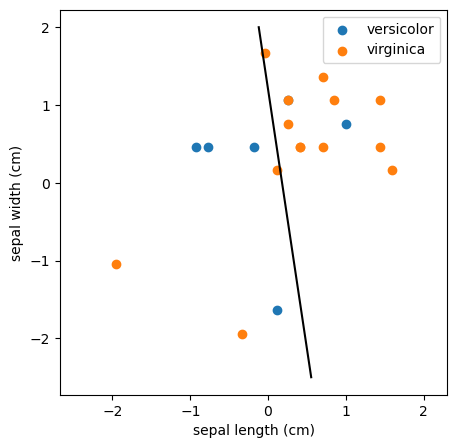

In [12]:
Xtest_scaled = model.named_steps['scaler'].transform(X_test)

plt.figure(figsize=(5,5))
for output_class in range(2):
    ind = y_test==output_class
    plt.scatter(Xtest_scaled[ind,0],Xtest_scaled[ind,1],
                label=iris.target_names[binarizer.classes_[output_class]])
x2 = np.linspace(-2.5,2)
x1 = -(theta0 + theta[1]*x2)/theta[0]
plt.plot(x1,x2,'k')
plt.axis('equal')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend()

# 5. Compute the test accuracy

Use the model to make predictions for the test data, and store those predictions in `yhat`. Then use scikit-learn's `accuracy_score` method to estimate the accuracy of the model. 

In [13]:
from sklearn.metrics import accuracy_score

yhat = model.predict(X_test)
test_acc = accuracy_score(y_test, yhat)

In [14]:
grader.check("q5")

q5 results: All test cases passed!

# 6. Compute the prediction probabilities

Use the model's `predict_proba` method to estimate class probabilities for the test data points. Notice that the probabilities for class 0 and class 1 add up to one for each test data point. Store the probabilities for class 1 in an array `yhat_proba`, whose shape should be `(20,)`.

In [15]:
yhat_proba = model.predict_proba(X_test)[:, 1]
print(yhat_proba)
yhat_proba.shape

[0.70645249 0.6714233  0.40515411 0.22148831 0.50913494 0.41076289
 0.85011999 0.55760248 0.57100837 0.57100837 0.84811455 0.73163383
 0.27362957 0.58810785 0.83352675 0.58810785 0.75540295 0.25392753
 0.05817622 0.48578862]


(20,)

In [16]:
grader.check("q6")

q6 results: All test cases passed!

# 7. Use scikit-learn to plot the ROC curve

See the documentation for scikit-learn's [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).
+ Plot the ROC curve based on the outputs of the `roc_curve` method. 
+ Add labels to the x and y axes. 

Text(0, 0.5, 'TPR')

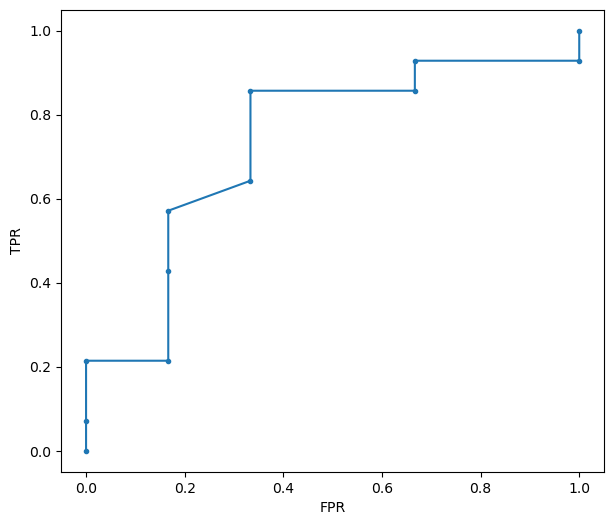

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, yhat_proba, pos_label=1)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, '.-')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [18]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Compute performance metrics

## 8.1. Allocate arrays

Define:
+ `N`: Total number of test samples
+ `Nn`: Number of negative samples (corresponding to y_test==0)
+ `Np`: Number of postive samples (corresponding to y_test==1)
+ Allocate arrays for the performance metrics.
    + `TPR`: True positie rate
    + `TNR`: True negative rate
    + `A`: Accuracy
    + `Cost`: Cost 
The length of these arrays should equal the number of test data points.

In [19]:
N = len(X_test)
Nn = sum(y_test == 0)
Np = sum(y_test == 1)


TPR = np.empty(N)
TNR = np.empty(N)
A = np.empty(N)
Cost = np.empty(N)

In [20]:
grader.check("q8p1")

q8p1 results: All test cases passed!

## 8.2. Compute performance metrics

Next we will compute the value of the four performance metrics (`TPR`, `TNR`, `A`, `Cost`) as the classification threshold varies along the ROC curve. 

`Cost` is computed assuming that a false positive is 5 times more costly than a false negative, and that there is zero profit associated with true positives and true negatives. 

`Cost` = 5*`FP` + `FN`

Follow these steps in the calculation:
1. Make a sorted copy of `yhat_proba`, and call it `Rho`. Hints: [copy()](https://numpy.org/doc/stable/reference/generated/numpy.copy.html), [sort()](https://www.google.com/search?channel=fs&client=ubuntu&q=numpy+sort)
2. Iterate through the sorted thresholds. For each one, make predictions for the test data using the formula:

$$
\hat{y} = \left\{
    \begin{array}\\
        1 & \mbox{if } \ p(Y=1|x)\geq\rho \\
        0 & \mbox{otherwise}
    \end{array}
\right.
$$

Store these in `ypred`

3. Compute the values of the confusion matrix (`TP`,`FP`,`TN`,`FN`) for each value of `Rho`.
4. Compute the corresponding performance metrics. 

In [21]:
# 1. Sorted thresholds
Rho = np.sort(np.copy(yhat_proba))

for i, rho in enumerate(Rho):
    
    # 2. Compute the positive and negative predictions using rho as the threshold
    # Hint: You don't need to use the model for this. Only yhat_proba. 
    ypred = np.empty(N)
    for j in range(len(yhat_proba)):
        ypred[j] = 1 if yhat_proba[j] >= rho else 0

    # 3. Confusion matrix
    TP = sum((ypred == 1) & (y_test==1))
    FP = sum((ypred == 1) & (y_test==0))
    TN = sum((ypred == 0) & (y_test==0))
    FN = sum((ypred == 0) & (y_test==1))

    # 4. Performance metrics
    TPR[i] = TP/(TP+FN)
    TNR[i] = TN/(TN+FP)
    A[i] = (TP+TN)/N
    Cost[i] = 5*FP + FN

In [22]:
grader.check("q8p2")

q8p2 results: All test cases passed!

# 9. Best threshold for accuracy

Report the optimal accuracy and its corresponding probability threshold value.

In [23]:
ind = np.argmax(A)
rhoA = Rho[ind]
Abest = A[ind]

In [24]:
grader.check("q9")

q9 results: All test cases passed!

# 10. Plot

Plot the accuracy vs threshold curve and indicate the optimal point with a marker. [1 point]

Text(0, 0.5, 'Accuracy')

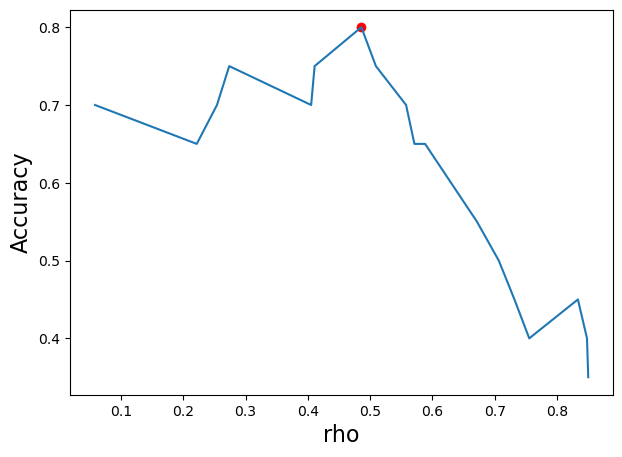

In [25]:
plt.figure(figsize=(7,5))
plt.plot(Rho, A)
plt.scatter(rhoA, Abest, color = 'r', marker = 'o')
plt.xlabel('rho',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

# 11. Best threshold for cost

Report the optimal cost and its corresponding probability threshold value.

In [26]:
rhoC = Rho[np.argmin(Cost)]
Cbest = min(Cost)

In [27]:
grader.check("q11")

q11 results: All test cases passed!

# 12. Plot

Plot the cost vs threshold curve and indicate the optimal point with a marker. [1 point]

Text(0, 0.5, 'Cost')

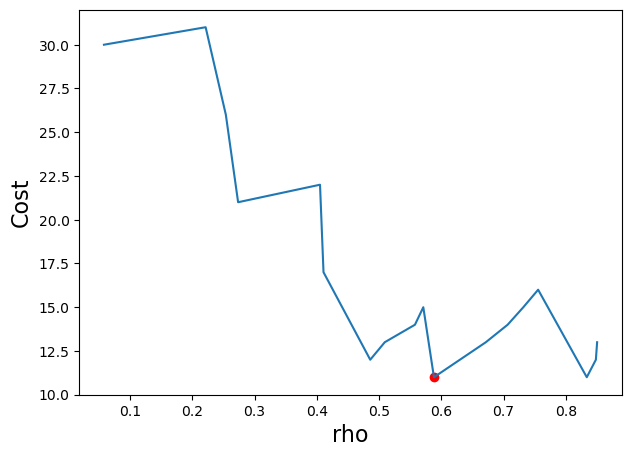

In [28]:
plt.figure(figsize=(7,5))
plt.plot(Rho, Cost)
plt.scatter(rhoC, Cbest, color = 'r', marker = 'o')
plt.xlabel('rho',fontsize=16)
plt.ylabel('Cost',fontsize=16)

# 13. ROC curve

Plot the true positive rate vs the false positive rate. Use the same markers to indicate the optimal accuracy and optimal cost solutions. [2 points]

Text(0, 0.5, 'TPR')

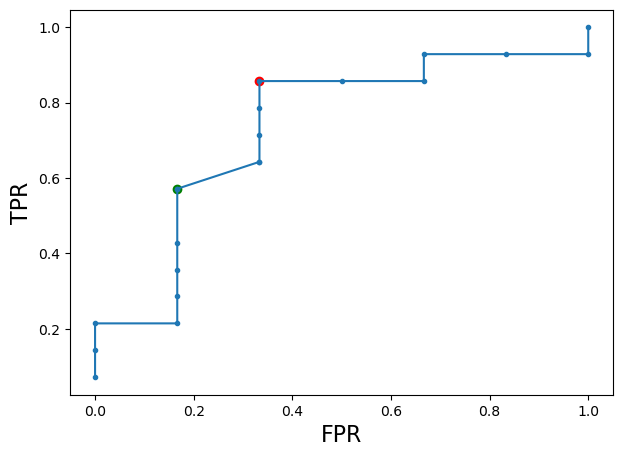

In [29]:
plt.figure(figsize=(7,5))
FPR = 1 - TNR
plt.plot(FPR, TPR, '.-')
plt.scatter(FPR[np.argmax(A)], TPR[np.argmax(A)], color = 'r', marker = 'o')
plt.scatter(FPR[np.argmin(Cost)], TPR[np.argmin(Cost)], color = 'g', marker = 'o')
plt.xlabel('FPR',fontsize=16)
plt.ylabel('TPR',fontsize=16)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [30]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4 results: All test cases passed!

    q5 results: All test cases passed!

    q6 results: All test cases passed!

    q7 results: All test cases passed!

    q8p1 results: All test cases passed!

    q8p2 results: All test cases passed!

    q9 results: All test cases passed!

    q11 results: All test cases passed!
